<a href="https://colab.research.google.com/github/lephuocdat2000/Tu-hu/blob/main/Description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('./content')

Mounted at ./content


#Mô tả tập dữ liệu

Tập dữ liệu review trên trang Foody với khoảng 30,000 mẫu được gán nhãn. Trong đó có 15,000 mẫu positive và 15,000 mẫu negative. Nguồn: https://streetcodevn.com/blog/dataset. 

#Các bước huấn luyện

Có 5 bước chính để giải quyết bài toán phân tích cảm xúc trong văn bản:

1) Huấn luyện một mô hình phát sinh ra vector từ (như mô hình Word2Vec) hoặc tải lên các vector từ tiền huấn luyện.

2) Tạo ma trận ID cho tập dữ liệu huấn luyện


3) Tạo mô hình RNN với các đơn vị LSTM, sử dụng tensorflow

4) Huấn luyện mô hình RNN với dữ liệu ma trận đã tạo ở bước 2

5) Đánh giá mô hình đã huấn luyện với tập test

##1>Load tập từ vựng và ma trận word embedding 

Đầu tiên, để có thể biến đổi một từ thành một vector, chúng ta sử dụng mô hình đã được huấn luyện trước đó (pretrained model). Mô hình đã train trước đó cho tiếng Việt được lấy ở đây: https://s3-us-west-1.amazonaws.com/fasttext-vectors/word-vectors-v2/cc.vi.300.vec.gz

Tuy nhiên, số lượng từ vựng tiếng Việt được huấn luyện rất lớn, khoảng 2M từ. Mỗi từ được biểu diễn dưới dạng một vector 300 chiều. Với kích thước gốc của ma trận word embedding như vậy sẽ gây khó khăn cho việc load dữ liệu cũng như đưa vào thư viện tensorflow để huấn luyện nên chúng tôi đã tối giản lại với số lượng từ tối thiểu để có thể chạy được trên tập dữ liệu review về đồ ăn của Foody.


In [5]:
import numpy as np
import os

#currentDir là mục chứa wordList.npy và wordVectors.npy
currentDir = '/content/content/MyDrive/Deep Learning/Assignment3-SentimentAnalysis-with-LSTM'
#file wordList.npy là file gồm những từ có trong 30000 câu tập huấn luyện về Foody  
wordsList = np.load(os.path.join(currentDir, 'wordsList.npy'))
print('Simplified vocabulary loaded!')
wordsList = wordsList.tolist()

#wordVectors là tập ma trận embedding của những từ có trong wordsList được lấy ra từ tập pretrained Word2Vec ở trên
wordVectors = np.load(os.path.join(currentDir, 'wordVectors.npy'))
wordVectors = np.float32(wordVectors)
print ('Word embedding matrix loaded!')

Simplified vocabulary loaded!
Word embedding matrix loaded!


Để chắc chắn mọi dữ liệu được load lên một cách chính xác, chúng ta cần kiểm tra xem số lượng từ trong từ điển rút gọn và số chiều của ma trận word embedding có khớp với nhau hay không? Trong trường hợp này số từ mà chúng tôi giữ lại là 19,899 và số chiều trong không gian biểu diễn là 300 chiều.

In [6]:
print('Size of the vocabulary: ', len(wordsList))
print('Size of the word embedding matrix: ', wordVectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


Ví dụ để hiểu rõ hơn: Giả sử ở trong wordsList từ "ngon" nằm ở index thứ i , để lấy được vector biểu diễn của từ "ngon" ta sẽ lấy 
wordVector[i] với shape = 1x300

##2>Khảo sát tập dữ liệu huấn luyện và tạo ma trận ID 

Tập dữ liệu lấy từ trang web Foody trên miền dữ liệu liên quan đến ẩm thực. Tập dữ liệu bao gôm 15.000 review tích cực đặt trong thư mục 'positiveReviews' và 15.000 review tiêu cực đặt trong thư mục 'negativeReviews'. Do khối lượng dữ liệu lớn, nếu chúng ta chọn số lượng từ tối đa (maxSeqLength) quá cao thì sẽ bị lãng phí khi biểu diễn ở những câu review quá ngắn. Ngược lại, nếu sử dụng số lượng từ tối đa quá ít thì sẽ bị bỏ lỡ những từ quan trọng giúp cho việc phân tích cảm xúc.



In [16]:
from os import listdir
from os.path import isfile, join
positiveFiles = [currentDir+'/positiveReviews/' + f for f in os.listdir(currentDir+ '/positiveReviews')]
negativeFiles = [currentDir+'/negativeReviews/' + f for f in os.listdir(currentDir+ '/negativeReviews')]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 30000
The total number of words in the files is 1770824
The average number of words in the files is 59.02746666666667


Chúng ta có thể sử dụng thư viện Matplot để minh hoạ phân bố về chiều dài của các câu review trong tập dữ liệu:

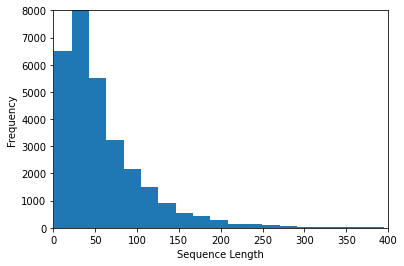

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 400, 0, 8000])
plt.show()

Dựa trên biểu đồ histogram ở trên chúng ta có thể thấy 180 sẽ là lựa chọn tương đối hợp lý.

In [23]:
maxSeqLength = 180

Để có cảm nhận rõ hơn về dữ liệu, chúng ta có thể hiển thị một số review bất kỳ như sau.

In [24]:
print('A positive sentence: ')
fname = positiveFiles[3] # Randomly select a positive file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)

print('A negative sentence: ')
fname = negativeFiles[10] # Randomly select a negative file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)


A positive sentence: 
Nghe game đc khoảng tháng nay mà CN vừa_rồi mới có dịp đi chơi thử : D . công_nghệ fai nói là siêu hiện_đại , nhìu fen bất_ngờ lắm luôn : ) ) chơi room Pharaoh mà cứ tưởng mình đi zô lăng_mộ thiệt á . > . < Mới đi lần đầu nên còn lóng_ngóng ko kịp thời_gian escape T^ T cơ_mà siêu vui , hẹn CN tuần tới sẽ quay lại thử_thách lần nữa : 3

A negative sentence: 
Món ăn ngồi . Tuy_nhiên phục_vụ không chuyên_nghiệp . Nhà_hàng đông nên nhân_viên hay quên đồ , nhầm đồ hay đi lóng_ngóng và làm đổ_vỡ . Thời_gian gọi trung_bình là 30 ' một món .

Chấm điểm : 7 ( - 1 ) / 10 ( trừ 1 vì phục_vụ rất chán )



##Chuẩn hóa văn bản và tách từ

Tập dữ liệu đã được tách từ. Giữa hai từ có thể ghép lại để tạo thành một khái niệm mới chúng ta sử dụng ký tự '_' để nối các từ đó. Ví dụ: 'sinh_viên', 'sinh_học'.

Sử dụng một hàm để xử lý và chuẩn hóa văn bản là 'cleanSentences'.

In [25]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^\w0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Bây giờ chúng ta sẽ biểu diễn 30.000 review dưới dạng các chỉ số của các từ. Tập dữ liệu positive và negative sẽ được tính hợp lại thành một ma trận 30000x180. Trong đó 30000 là số lượng review và 180 là số lượng từ tối đa cho một câu. Do bước chuẩn bị này tốn khá nhiều tài nguyên tính toán nên sau khi tính toán xong, chúng ta sẽ lưu lại để sử dụng cho những lần chạy thí nghiệm sau. Ma trận lưu trữ các chỉ số này là: 'ids'.

###Xác định chỉ số của từng từ trong review

Trong phần này chúng ta sẽ tiến hành tra cứu từng từ trong review, sau đó gán vào ma trận 'ids'. Trong đó chỉ số dòng của ma trận tương ứng với file review, chỉ số cột của ma trận tương ứng với một từ của review. Trường hợp từ nào không có trong tập từ điển thì ta sẽ gán bằng chỉ số của từ 'UNK' (unknow).

In [ ]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
nFiles = 0
# Index of Unknow word
unk_idx = wordsList.index('UNK')

for pf in positiveFiles:
    with open(pf, "r", encoding="utf-8") as f:
        nIndexes = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            # Nếu 'word' thuộc tập 'wordsList' thì gán chỉ số của 'word' vào ma trận ids
            if word in wordsList:
               word_idx = wordsList.index(word)
               ids[nFiles][word_idx] = word_idx
            # Ngược lại: gán 'unk_idx' vào ma trận ids
            else: ids[nFiles][word_idx] = unk_idx
            nIndexes = nIndexes + 1
            if nIndexes >= maxSeqLength:
                break
        nFiles = nFiles + 1 
print('Positive files are indexed!')

#Làm tương tự với file negative
for nf in negativeFiles:
    with open(nf, "r", encoding="utf-8") as f:
        nIndexes = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
             if word in wordsList:
               word_idx = wordsList.index(word)
               ids[nFiles][word_idx] = word_idx
            else: ids[nFiles][word_idx] = unk_idx.
            nIndexes = nIndexes + 1
            if nIndexes >= maxSeqLength:
                break
        nFiles = nFiles + 1 

print('Negative files are indexed!')

# Lưu lại ma trận ids để tiết kiệm thời gian
np.save(os.path.join(currentDir,'idsMatrix.npy'), ids)

In [27]:
#Bước thực hiện trên tương đối mất thời gian.
# Trường hợp đã tính toán và lưu ma trận 'ids' rồi thì ta có thể load lên để sử dụng luôn
ids = np.load(os.path.join(currentDir,'idsMatrix.npy'))
print('Word indexes of the first review: ', ids[0])

Word indexes of the first review:  [19898  1906  4454  5284 10661 11694 11994 18784 18569 18619 13174  9821
 14794  8884  6443  5767  8589 18850 15570  5596   799 11060  4222 16893
 13078  8136  3364  4454  4756 10304  8885  3553  9782  1232 14359 10606
   579 15522  2219 15092 14855 15253  4884  3364  5519  4558  9649   269
 15522 12309 14855 11503  2212  4884  7155 11577  4222  5767 15076 12225
 10774  1218  2876 19584  4558  2974 13452  5013   842 10642 17292 11895
   803 11060 16760  1906 15253 14598 15253  1047  5668  4884 10642 12225
  7090 17292 18109 13078 16334  1238  3364  5519  4135  3553 14967  4964
 15385  9673  2997 14855  7446  8038 11440  1345   842  5767   803 11060
 18791  5013     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

#3> Xây dựng RNN với Tensorflow

Đầu tiên chúng tôi sẽ khởi tạo các tham số cho mô hình mạng RNN với các cell là các LSTM. Kiến trúc mạng ở đây bao gồm 128 đơn vị cho mỗi lớp, số lượng layer là 2, số lượng phân lớp là 2 và số vòng lặp khi huấn luyện là 30000.

In [28]:
# Initialize paramters
numDimensions = 300
batchSize = 64
lstmUnits = 128
nLayers = 2
numClasses = 2
iterations = 30000

Input của mạng là một câu đã được id hóa, output là một vector onehot với hai giá trị tương ứng với hai loại cảm xúc [1,0] positive và [0,1] negative 

Chia tập dữ liệu với 2000 câu test(50 pos: 50 neg) và 28000 câu train(50 pos: 50 train) 

In [29]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

X = ids.copy()
Y = np.concatenate((np.ones((15000,1)),np.zeros((15000,1))))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.067)

Cấu trúc mô hình:
- Với mỗi câu được id hóa đưa vào sẽ đi qua lớp Embedding và mỗi id đại diện cho một từ được chuyển hóa nhờ pretrained wordVectors thành vector 300 chiều.
- Để tăng tính phức tạp cho mô hình ta sẽ xếp 2 lớp LSTM chồng lên nhau
- Để tránh overfit ta sẽ xen giữa 2 lớp LSTM một lớp Dropout
- Tiếp theo là một lớp fullyconnected 
- Cuối cùng là một lớp softmax để đưa ra kết quả là vector one-hot


In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "/content/content/MyDrive/Deep Learning/Assignment3-SentimentAnalysis-with-LSTM/training_2/weights.{epoch:04d}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model = keras.Sequential([
        layers.Embedding(input_dim=19899,output_dim=numDimensions,weights=[wordVectors],input_length=maxSeqLength,trainable=False),
        layers.LSTM(lstmUnits,return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(lstmUnits),
        layers.Flatten(),
        layers.Dense(2,activation='softmax')]
 )
model.save_weights(checkpoint_path.format(epoch=0))

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='Adam',
    metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batchSize, epochs=iterations,callbacks=[cp_callback,es_callback])

Ở epoch thứ 20 thì ta dừng lại vì accuracy trên tập test không tăng được nữa

Visualize lost

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['train_loss']
loss_val = history.history['val_loss']
epochs = range(1,20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualize accuracy

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#4> Inference

Load weight đã train

In [18]:
#weight_path là đường dẫn đến thư mục chứa file weight
weight_path = 'training_1/weights.0020.hdf5'
model.load_weights(weight_path)

NameError: ignored

Hàm tiền xử lí

In [ ]:
import re
strip_special_chars = re.compile("[^\w0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def Predict_Sentence(sentence,model):
   cleaned = cleanSentences(sentence)
   words = cleaned.split()
   word_vec = np.zeros((1,maxSeqLength))
   for i,word in enumerate(words):
      if word in wordsList:
        word_idx = wordsList.index(word)
      else:
        word_idx = wordsList.index('UNK')
      word_vec[0][i] = word_idx
   result = model.predict(word_vec)
   if np.argmax(result[0])==1: print('Positive')
   else: print('Negative')

Predict

In [ ]:
Predict_Sentence('Múp rụp',model)